In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ML Libraries
from Model import getPredictions
from Accuracy import printMeanAbsoluteError, printMeanAbsolutePercentageError
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from ModelEvaluation import tryParameters
from VisualizeData import featureImportance, featuresCorrelation
from sklearn.model_selection import cross_val_score

#WebScarping / API / Visualization
from VisualizeData import showBarChart, showHeatMap, showScatterPlotLine, plotPredictionsTowardsActual, plotThreeDimensionsGraph, plot3DWireframe
from mpl_toolkits.mplot3d import Axes3D

import time

In [380]:
apData = pd.read_csv('./Data/ScrappedDataClean.csv')
apData.info()
# Step 3 - Get a trained model based on dataframe, Features = 6
#featuresToTrainOn = ['Size', 'NearbyPOIs', 'Latitude', 'Longitude','Rooms','Rent','Date']
featuresToTrainOn = ['Size', 'NearbyPOIs', 'Latitude', 'Longitude','Rooms']
target = 'Price'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912 entries, 0 to 3911
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3912 non-null   float64
 1   Adress        3912 non-null   object 
 2   Size          3912 non-null   float64
 3   Rooms         3912 non-null   float64
 4   Broker        3912 non-null   object 
 5   Rent          3912 non-null   float64
 6   Price         3912 non-null   float64
 7   NearbyPOIs    3912 non-null   float64
 8   Latitude      3912 non-null   float64
 9   Longitude     3912 non-null   float64
 10  PricePerKvm   3912 non-null   float64
 11  PricePerRoom  3912 non-null   float64
dtypes: float64(10), object(2)
memory usage: 366.9+ KB


In [381]:
#X = apData[featuresToTrainOn].values     # predictor feature columns (4 X m)
#y = apData['Price'].values # predicted class (1=true, 0=false) column (1 X m)
#split_test_size = 0.20
# X
target = apData[target]
#y
apData = apData[featuresToTrainOn]

In [382]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42) 
# test_size = 0.2 is 20%, 42 is the answer to everything for the random split.
trainFeatures, valFeatures, trainPredictionTarget, valPredictionTarget = train_test_split(apData, target, random_state=0)

In [383]:
print(len(trainFeatures))
print(len(valFeatures))
print(len(trainPredictionTarget))
print(len(valPredictionTarget))

2934
978
2934
978


In [384]:
#test splitting 80/20
print("{0:0.2f}% in training set".format((len(trainFeatures)/len(apData.index)) * 100))
print("{0:0.2f}% in test set".format((len(valFeatures)/len(apData.index)) * 100))

75.00% in training set
25.00% in test set


In [385]:
# compare MAE (Mean Absolut Error) with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 100, 200, 1000, 2000, 3000]:
    model = RandomForestRegressor(
            max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(trainFeatures, trainPredictionTarget.values.ravel())
    preds_val = model.predict(valFeatures)
    mae = mean_absolute_error(valPredictionTarget, preds_val)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %
              (max_leaf_nodes, mae))

Max leaf nodes: 5  		 Mean Absolute Error:  762684
Max leaf nodes: 50  		 Mean Absolute Error:  514349
Max leaf nodes: 100  		 Mean Absolute Error:  489473
Max leaf nodes: 200  		 Mean Absolute Error:  476152
Max leaf nodes: 1000  		 Mean Absolute Error:  478774
Max leaf nodes: 2000  		 Mean Absolute Error:  479071
Max leaf nodes: 3000  		 Mean Absolute Error:  479071


In [387]:
trainedModel = RandomForestRegressor(random_state=1, max_leaf_nodes=350)

In [388]:
#trainedModel.fit(trainFeatures, trainPredictionTarget.values.ravel())
trainedModel.fit(trainFeatures, trainPredictionTarget)

RandomForestRegressor(max_leaf_nodes=350, random_state=1)

feature_importances [0.0390977  0.63449526 0.16548015 0.15885214 0.00207475]


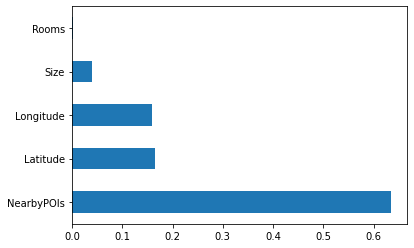

In [389]:
# Test which features affect the prediction target the most
print("feature_importances", trainedModel.feature_importances_)
feat_importances = pd.Series(
    trainedModel.feature_importances_, index=trainFeatures.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

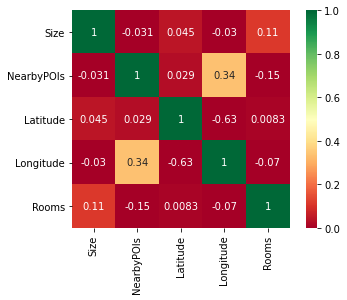

In [390]:
# Test which features affect the prediction target the most
corrmat = apData.corr()
top_corr_features = corrmat.index
# plot heat map
g = sns.heatmap(apData[top_corr_features].corr(), vmin=0,
                vmax=1, annot=True, cmap="RdYlGn", square=True)
plt.show()

In [391]:
modelPredictions = trainedModel.predict(valFeatures)

In [392]:
mae_error = mean_absolute_error(valPredictionTarget, modelPredictions)
mae_error = round(mae_error, 0)
mae_error = '{:,.2f}'.format(mae_error)

print("Predictions for", len(modelPredictions), "apartments are off (MAE) by:")
print(mae_error, "SEK")

Predictions for 978 apartments are off (MAE) by:
473,082.00 SEK


In [393]:
valPredictionTarget, predictions = np.array(
    valPredictionTarget), np.array(modelPredictions)
maeP = np.mean(
    np.abs((valPredictionTarget - modelPredictions) / valPredictionTarget)) * 100
maeP = round(maeP, 2)
print("Predictions for", len(modelPredictions), "apartments are off (MAPE) by:")
print(maeP, "%")

Predictions for 978 apartments are off (MAPE) by:
11.28 %


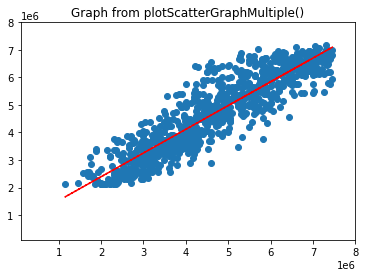

R2 (cross validation mean): 0.70 (+/- 0.10)


In [394]:
plt.title('Graph from plotScatterGraphMultiple()')
plt.axis([100000, 8000000, 100000, 8000000])
plt.scatter(valPredictionTarget, modelPredictions)

z = np.polyfit(valPredictionTarget, modelPredictions, 1)
p = np.poly1d(z)
plt.plot(valPredictionTarget, p(valPredictionTarget), "r--")

plt.show()

# Cross validation using R2 as cv-score
KFold = 10
cv_score = cross_val_score(reg, valFeatures, valPredictionTarget, cv=KFold, scoring ='r2')
print("R2 (cross validation mean): %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))